In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

df = pd.read_csv("input.csv")
df["row_id"] = df.index

url_df = pd.melt(df, id_vars=["row_id"], value_vars=["Left", "Right", "Center"],
                 var_name="leaning", value_name="url")

stop_map = {"Left": "LeftStop", "Right": "RightStop", "Center": "CenterStop"}
start_map = {"Left": "LeftStart", "Right": "RightStart", "Center": "CenterStart"}


url_df["stop_phrase"] = url_df.apply(
    lambda row: df.loc[row["row_id"], stop_map[row["leaning"]]]
    if stop_map[row["leaning"]] in df.columns else None,
    axis=1
)

url_df["start_phrase"] = url_df.apply(
    lambda row: df.loc[row["row_id"], start_map[row["leaning"]]]
    if start_map[row["leaning"]] in df.columns else None,
    axis=1
)

url_df.dropna(subset=["url"], inplace=True)


headers = {"User-Agent": "Mozilla/5.0"}
data = []

for _, row in url_df.iterrows():
    url = row["url"]
    start_phrase = row["start_phrase"]
    stop_phrase = row["stop_phrase"]
    leaning = row["leaning"]

    response = requests.get(url, headers=headers)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, 'html.parser')
    title = soup.find('h1').get_text(strip=True) if soup.find('h1') else "No title"
    title = title.replace(',', '')

    for a in soup.find_all('a'):
        a.insert_before(' ')
        a.insert_after(' ')

    if isinstance(start_phrase, str) and start_phrase.strip():
        for p in soup.find_all('p'):
            text = p.get_text()
            if isinstance(start_phrase, str) and start_phrase.strip() and start_phrase in text:
                p.extract()
                break
            else:
                p.extract()

    paragraphs = []
    for p in soup.find_all('p'):
        text = p.get_text()
        if isinstance(stop_phrase, str) and stop_phrase.strip() and stop_phrase in text:
            break
        paragraphs.append(text)

    content = "\n".join(paragraphs)
    content = content.replace(',', '')

    data.append({
        "url": url,
        "leaning": leaning,
        "title": title,
        "content": content
    })


result_df = pd.DataFrame(data)
result_df.to_csv("articles_scraped.csv", index=False)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for wordcloud
  Running setup.py clean for wordcloud
Failed to build wordcloud
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (wordcloud)


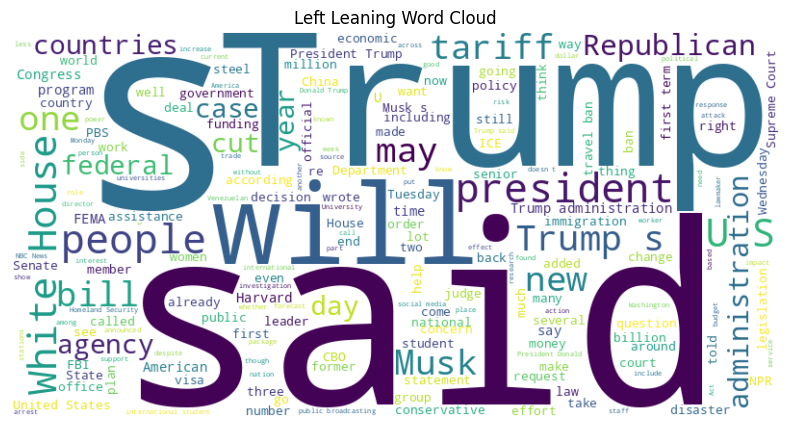

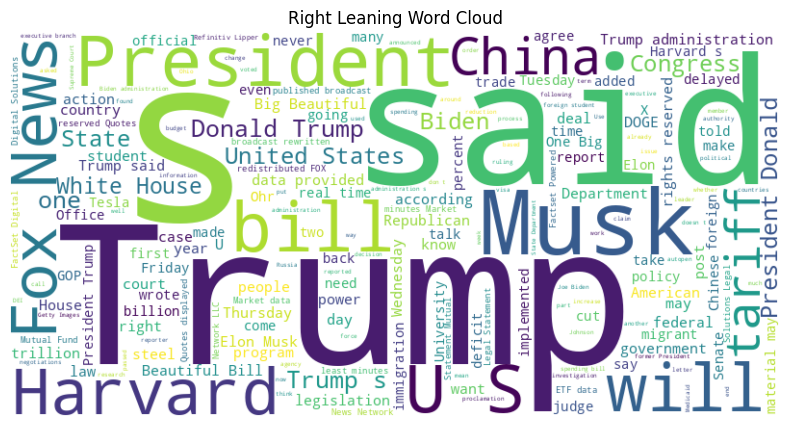

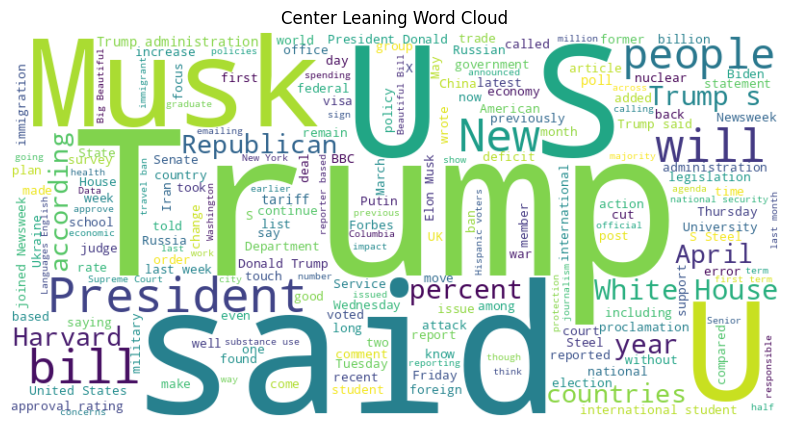

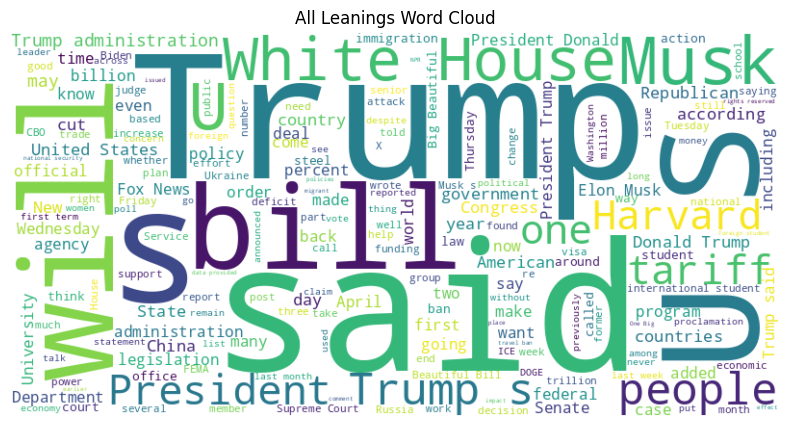

In [ ]:
!pip install wordcloud==1.8.1
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

result_df = pd.read_csv("articles_scraped.csv")

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

left_content = " ".join(result_df[result_df['leaning'] == 'Left']['content'].astype(str))
right_content = " ".join(result_df[result_df['leaning'] == 'Right']['content'].astype(str))
center_content = " ".join(result_df[result_df['leaning'] == 'Center']['content'].astype(str))
all_content = " ".join(result_df['content'].astype(str))

generate_wordcloud(left_content, "Left Leaning Word Cloud")
generate_wordcloud(right_content, "Right Leaning Word Cloud")
generate_wordcloud(center_content, "Center Leaning Word Cloud")
generate_wordcloud(all_content, "All Leanings Word Cloud")